# Introduction

This project is a collaboration with [Dr. Anas Ghrab](http://anas.ghrab.tn/en/), professor of musicology at the Music Institute, University of Sousse, Tunisia.

The goal of this project is to analyze the [Saramusik digital corpus](http://saramusik.org/) using modern tools of data science, natural language processing and machine learning. Saramusik is an online catalogue of (mostly old) Arabic texts on music, with currently a few (less than 100) electronic texts, created and maintained by Dr. Anas Ghrab.

The documents are automatically pulled from the [Saramusik online database](http://saramusik.org/). The database currently comprises a little less than 50 documents, but is set to increase to hundreds of documents within a year. 

The documents are encoded in XML format based on the [Text Encoding Initiative (TEI)](https://tei-c.org/). In addition to the textual content of the document, each xml file contains some metadata such as the author, the source of the document, and a set of tags that indicate the genre(s) of the document.

Some of the preliminary research questions we aim to answer are:

1. Can we group the documents into a small number of groups (*clusters*) of documents with similar content?
2. Which vocabulary terms most/best characterize the content of each cluster?
3. How do these clusters correlate with other document characteristics, such as: i) tags, ii) geographic location, and iii) time period?  In other words, do documents of the same cluster necessarily have the same tags, or belong to the same time period?

In [1]:
# hide

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

import arabic_reshaper
from bidi.algorithm import get_display

from tabulate import tabulate

In [2]:
# hide

from nltk import FreqDist

# Data acquisition

The Saramusik digital repository currently contains around 50 documents encoded in xml format. We remove documents that contain very little content, so we end up with only of 39 documents. 

For each document we automatically extract the textual content and some metadata from the corresponding xml file and store it in a pandas data frame. Below is a brief description of the columns of this data frame.

- `title_arabic`: title in Arabic.
- `title_translit`: title transliterated into latin characters.
- `author`: name of the original author in Arabic.
- `tags`: one or more text labels indicating the musical genre of the document.
- `library_locations`: name of country where physical or electronic copies of the document are located.
- `raw_text`: textual content (Arabic).

In [3]:
# hide

import pickle

with open('../pickle_files/doc_parsed_data.pickle', 'rb') as f:
    doc_data_df = pickle.load(f)

doc_data_df.drop(['hyperlink','filename','section_titles'],axis=1,inplace=True)
doc_data_df.rename(columns = {'source':'library_locations'}, inplace = True)
doc_data_df.rename(columns = {'raw_text':'text_content'}, inplace = True)
doc_data_df = doc_data_df[['title_arabic','title_latin_translit','author','tags', 'library_locations','text_content']]
type(doc_data_df),doc_data_df.shape

(pandas.core.frame.DataFrame, (39, 6))

The first 5 rows of this data frame.

In [4]:
doc_data_df.head()

,title_arabic,title_latin_translit,author,tags,library_locations,text_content
0,رسالة في خبر صناعة التّأليف,risāla fī ẖabar ṣināʿat al-taʾlīf,يعقوب بن إسحاق الكندي,"[الموسيقى والفلسفة, المدرسة الأفلاطونيّة المتج...",[بريطانيا العظمى],[بالاعتماد على تحقيق يوسف شوقي.]\n[الرّسالة من...
1,كتاب المصوّتات الوتريّة من ذات الوتر الواحد إل...,kitāb al-muṣawwiṭāt al-watariyya min ḍāt al-wa...,يعقوب بن إسحاق الكندي,"[الموسيقى والفلسفة, المدرسة الأفلاطونيّة المتج...",[بريطانيا العظمى],[اعتمادا على تحقيق زكريّا يوسف]\n\nأَطَالَ الَ...
2,رسالة في أجزاء خبريّة في الموسيقى,risāla fī aǧzāʾ ẖabariyya fī al-mūsīqā,يعقوب بن إسحاق الكندي,[المدرسة الأفلاطونيّة المتجدّدة],"[ألمانيا, تونس, ألمانيا]",أنار إليه من خفيّات الأمور بموضحات الرّسوم أفض...
3,رسالة الكندي في اللّحون والنّغم,Risālat al-kindī fī al-luhūn wa al-naġam,يعقوب بن إسحاق الكندي,[المدرسة الأفلاطونيّة المتجدّدة],"[ألمانيا, تركيا, ألمانيا]",بِسْمِ اللَّهِ الرَّحْمَانِ الرَّحِيمِ\nوَمَا ...
4,كتاب الأدوار,Kitāb al-Adwār,صفي الدّين عبد المؤمن أبو يوسف بن فخر الأرموي,"[نظريّات موسيقيّة, المدرسة الأرمويّة]","[تونس, تونس, نمسا, سعوديّة, مصر, مصر, مصر, مصر...",الدَّسَاتِينُ هِيَ عَلَامَاتٌ تُوضَعُ عَلَى سَ...


The content of the first document:

In [5]:
print(doc_data_df.text_content[0])

[بالاعتماد على تحقيق يوسف شوقي.]
[الرّسالة منقوصة في بدايتها.]
وَ « ك » إِلَى « ا »
وَقَدْ بَيَّنَّا أَنَّ فَضْلَ
فَإِذًا، بُعْدُ « و » الَّتِي هِيَ مُطْلَقُ المَثْلَثِ مِنْ « ا » الَّتِي هِيَ أَوَّلُ دَسَاتِينِ المَثْنَى هُوَ البُعْدُ الَّذِي بِالخَمْسَةِ.
وَمِنَ الَّذِي بِالخَمْسَةِ وَالَّذِي بِالأَرْبَعَةِ رُكِّبَ الَّذِي بِالكُلِّ.
فَإذًا بُعْدُ « ا » مِنَ البَمِّ مِنْ « ا » مِنَ المَثْنَى هُوَ الَّذِي بِالكُلِّ. فَإِذًا نِسْبَةُ « ا » مِنَ البَمِّ إِلَى « ا » مِنَ المَثْنَى هِيَ نِسْبَةُ المُضَاعَفِ بِالإِثْنَينِ. فَبِالاضْطِرَارِ أَنْ تَكُونُ « ا » مِنَ المَثْنَى مِنْ كَيْفِيَّةِ « ا » مِنَ البَمِّ، لِمَا قَدَّمْنَا.
وَعَلَى هَذَا المِثَالِ يَتَتَالَى النَّغَمُ المُتَتَالِي فِي التَّشَابُهِ فِي الكَيْفِيَّةِ، فَإِنَّ « ب » مِنَ المَثْنَى هِيَ « ب » مِنَ
وَكَذَلِكَ « جـ » مِنَ المَثْنَى هِيَ « جـ » مِنَ البَمِّ.
وَ« د » مِنَ المَثْنَى « د » مِنَ البَمِّ، وَهْيَ « د » مِنَ الزِّيرِ.
وَكَذَلِكَ « و » مِنَ الزِّيرِ هِيَ « و » مِنَ المَثْلَثِ.
وَ « ز » مِنَ الزِّيرِ هِيَ « ز » مِنَ ال

The first document has two tags: الموسيقى والفلسفة and المدرسة الأفلاطونيّة المتجدّدة 

In [6]:
for x in doc_data_df.tags[0]:
    print(x)

الموسيقى والفلسفة
المدرسة الأفلاطونيّة المتجدّدة


The first document is located at a library in بريطانيا العظمى, i.e. 'Great Britain'.

In [7]:
print(doc_data_df.library_locations[0][0])

بريطانيا العظمى


#  Data understanding

A quick exploration of the major characteristics of our documents.

## Title

There are no duplicate document titles.

In [8]:
doc_data_df.title_arabic.nunique()

39

In [9]:
doc_data_df.title_arabic.tolist()

['رسالة في خبر صناعة التّأليف',
 'كتاب المصوّتات الوتريّة من ذات الوتر الواحد إلى ذات العشرة أوتار',
 'رسالة في أجزاء خبريّة في الموسيقى',
 'رسالة الكندي في اللّحون والنّغم',
 'كتاب الأدوار',
 'قول على اللّحون وصنعة المعازف ومخارج الحروف',
 'كتاب النّغم',
 'كتاب الشّفاء',
 'مسألة في الموسيقى',
 'كتاب عنصر الموسيقى وما افترقت عليه الفلاسفة من تركيبه ومايته',
 'كتاب إحصاء الإيقاعات',
 'القول على أجناس الّذي بالأربعة',
 'برء الأسقام، شرح القصيدة في الأنغام',
 'كتاب الامتاع والانتفاع في مسألة سماع السّماع',
 'كتاب الأمانات والاعتقادات',
 'في الموسيقى',
 'نظم شجرة الطّبوع والطّبائع',
 'رسالة في التّعريف ببعض كلمات فارسيّة وردت في تأليف شهاب الدّين العجمي في علم الموسيقى',
 'كتاب النّفس : القول في السّمع',
 'كتاب الإنعام في معرفة الأنغام',
 'رسالة الكشّاف في علم الأنغام / مقدّمة في علم الموسيقى',
 'كتاب المحاسن والمساوي',
 'كتاب في علم الموسيقى ومعرفة الانغام',
 'شرح كتاب الأدوار',
 'رسالة القيان',
 'طبقات المغنّين',
 'كتاب التّربيع والتّدوير',
 'العقد الفريد',
 'أرجوزة في الأنغام',
 'مقدّمة

## Tags

Tags are labels that are manually assigned by an expert indicating the various genres that a document may belong to.

There 16 different tags in our corpus. However, as shown in the frequency distrbution plots below, only 4 tags have at least 5 occurrences:

    'المدرسة الأفلاطونيّة المتجدّدة'
     'المدرسة الفارابيّة'
     'مدرسة الأراجيز والأنغام'
     'النّصوص الأدبيّة الخبريّة'

For the purposes of analysis, we will later aggregate infrequent tags into a single aggregate tag called 'فئات مجتمعة' (which translates to *Other* in Arabic).

**Number of tags per document**

According to the distribution below, most documents are labelled by a single tag.

Text(0, 0.5, 'number of documents')

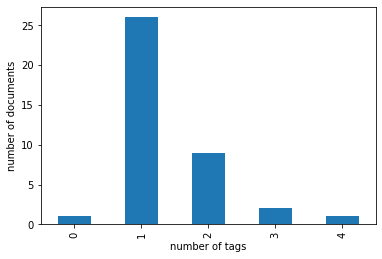

In [10]:
doc_data_df.tags.map(len).value_counts().sort_index().plot.bar()
plt.xlabel('number of tags')
plt.ylabel('number of documents')

**Frequency distribution of tags**

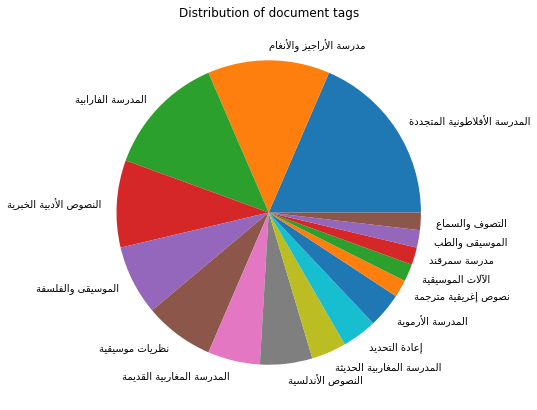

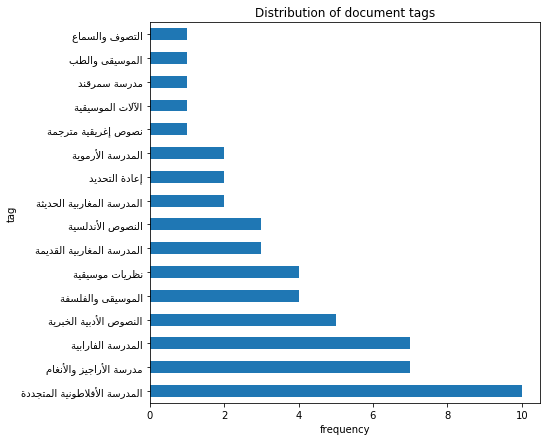

In [11]:
tags_flat_list = [y for x in doc_data_df.tags for y in x]
tags_df = pd.Series(tags_flat_list).value_counts()
tags_df = tags_df.reset_index()
tags_df.columns = ['tag','frequency']

tags_df['tag2'] = tags_df.tag.map(lambda tag: get_display(arabic_reshaper.reshape(tag)))

tags_df.set_index('tag2',inplace=True)

plt.figure(figsize=(7,7))
tags_df.frequency.plot(kind='pie')
plt.ylabel('')
plt.title('Distribution of document tags')
plt.show()

plt.figure(figsize=(7,7))
tags_df.frequency.plot(kind='barh')
plt.xlabel('frequency')
plt.ylabel('tag')
plt.title('Distribution of document tags')
plt.show()

**Co-occurrence of tags**

Based on the co-ocurrence matrix below, there is little redundancy between the tags.

Text(66.125, 0.5, 'tag')

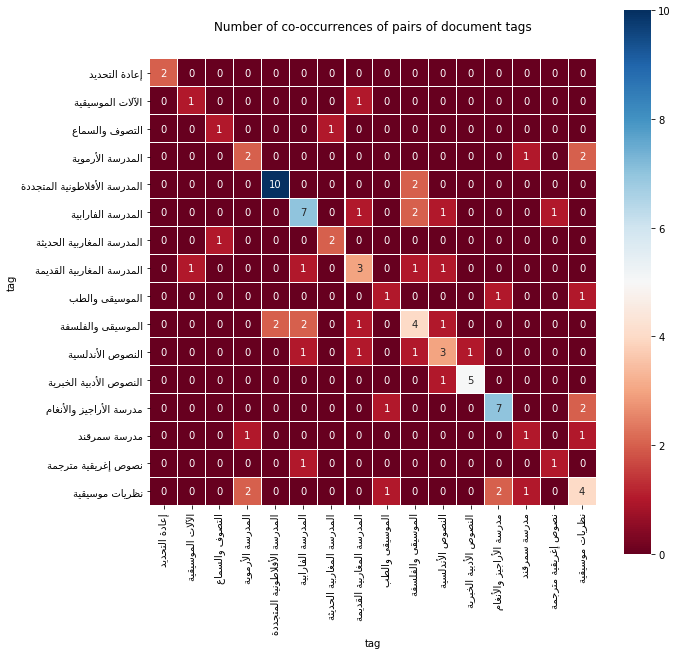

In [12]:
tags_list = doc_data_df.tags.tolist()
tags_distinct = sorted(list(set(tags_flat_list)))
doc_tags_mat = pd.np.zeros((len(tags_list),len(tags_distinct)))
for i,x in enumerate(tags_list):
    for j,y in enumerate(tags_distinct):
        if y in x:
            doc_tags_mat[i,j] = 1
doc_tags_df = pd.DataFrame(doc_tags_mat, columns=tags_distinct, index=doc_data_df.title_arabic)

C = pd.DataFrame(pd.np.asmatrix(doc_tags_df.T)*pd.np.asmatrix(doc_tags_df))
reshaped_tags = [get_display(arabic_reshaper.reshape(x)) for x in tags_distinct]
C.index = reshaped_tags
C.columns = reshaped_tags

plt.figure(figsize=(10,10))
plt.title('Number of co-occurrences of pairs of document tags', y=1.05, size=12)
sns.heatmap(C, linewidths=0.1, square=True, linecolor='white', annot=True, cmap=plt.cm.RdBu)
plt.xlabel('tag')
plt.ylabel('tag')

## Author

According to the output below, only 3 authors occur more than once, i.e. author more than one document in our corpus. The most occurring author is 'يعقوب بن إسحاق الكندي' who authored 4 of the documents in our corpus:

    'رسالة في خبر صناعة التّأليف'
     'كتاب المصوّتات الوتريّة من ذات الوتر الواحد إلى ذات العشرة أوتار'
     'رسالة في أجزاء خبريّة في الموسيقى'
     'رسالة الكندي في اللّحون والنّغم'


In [13]:
doc_data_df.author.value_counts().head()

يعقوب بن إسحاق الكندي                                   4
أبو عثمان عمر بن بحر الفُقيمي البصري الجاحظ             3
أبو نصر محمد بن محمد بن طرخان اوزلغ الفارابي            2
أبو عبد اللّه محمّد بن أحمد بن يوسف الكاتب الخوارزمي    1
مجهول 7                                                 1
Name: author, dtype: int64

In [14]:
doc_data_df.loc[doc_data_df.author=='يعقوب بن إسحاق الكندي','title_arabic'].tolist()

['رسالة في خبر صناعة التّأليف',
 'كتاب المصوّتات الوتريّة من ذات الوتر الواحد إلى ذات العشرة أوتار',
 'رسالة في أجزاء خبريّة في الموسيقى',
 'رسالة الكندي في اللّحون والنّغم']

## Text content

We want to know:

- What are the characters used in this corpus and how frequently do they occur.
- Are there any useless or noise characters that should be removed prior to analysis.

### Characterset

Number of characters: 542130

Number of distinct characters: 128

List of distinct characters:
['\t', '\n', ' ', '!', '"', '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '>', 'N', '[', ']', 'e', 'n', 'o', '{', '}', '~', '\xa0', '¦', '«', '»', 'έ', 'γ', 'ν', 'ο', 'ς', 'ג', 'ד', 'ה', 'ז', 'ח', 'כ', 'ן', '،', '؛', '؟', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', 'ٓ', 'ٔ', 'ٕ', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', '٬', '٭', 'ٱ', 'ە', '۟', '۴', '۵', '۶', '\u200f', '‘', '’', '“', '”', '…', '\u2028', '\u202c', '\u202e', '❊']

The 20 most common characters:
[(' ', 82207), ('ا', 49313), ('ل', 41807), ('َ', 31558), ('ي', 22936), ('و', 22492), ('ن', 22113), ('م', 21927), ('ِ', 15484), ('ر', 14677), ('ه', 14295), ('ب', 13448), ('ّ', 12773), ('ت', 12313), ('ع', 1207

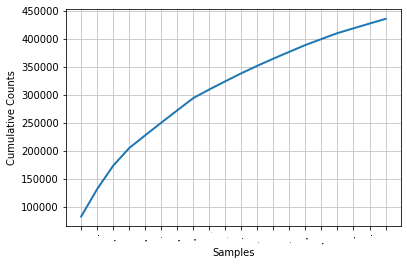

In [27]:
def analyze_corpus_charset(corpus):
    fdist = FreqDist([c for doc in corpus for c in doc])

    corpus_chars_df = pd.DataFrame(fdist.items())
    corpus_chars_df.columns = ['character','frequency']
    corpus_chars_df['unicode_dec']= corpus_chars_df.character.map(ord)
    corpus_chars_df['unicode_hex']= corpus_chars_df.character.map(lambda x: hex(ord(x)))
    corpus_chars_df = corpus_chars_df.set_index('character')

    print("Number of characters: %d" %fdist.N())
    print("\nNumber of distinct characters: %d" %fdist.B())

    #idx1= (corpus_chars_df.unicode_hex.map(len)==5) & (corpus_chars_df.unicode_hex.str.startswith('0x64')|corpus_chars_df.unicode_hex.str.startswith('0x65'))
    #idx2 = (corpus_chars_df.unicode_hex.str.startswith('0xfb') | corpus_chars_df.unicode_hex.str.startswith('0xfc') | corpus_chars_df.unicode_hex.str.startswith('0xfd') | corpus_chars_df.unicode_hex.str.startswith('0xfe')) & (corpus_chars_df.unicode_hex.map(len)==6)
    #print("\nNumber of characters from the Standard Arabic character set: %d" %idx1.sum())

    print('\nList of distinct characters:')
    print(sorted(list(fdist.keys())))

    print('\nThe 20 most common characters:')
    print(fdist.most_common(20))

    print('\nThe 20 least common characters:')
    print(fdist.most_common()[-20:])

    print("\nThe cumulative frequency distribution of the top 20 characters")
    fdist.plot(20, cumulative=True)

    return corpus_chars_df

corpus_chars_df = analyze_corpus_charset(doc_data_df.text_content)

In [16]:
# common characters

idx = corpus_chars_df.frequency>150
corpus_chars_df[idx].sort_values(by='unicode_dec')

,frequency,unicode_dec,unicode_hex
character,,,
\n,3773,10,0xa
,82207,32,0x20
!,207,33,0x21
"""",317,34,0x22
*,2068,42,0x2a
-,301,45,0x2d
.,3164,46,0x2e
:,1939,58,0x3a
[,580,91,0x5b


In [17]:
# rare characters

idx = corpus_chars_df.frequency<=150
corpus_chars_df[idx].sort_values(by='unicode_dec')

,frequency,unicode_dec,unicode_hex
character,,,
\t,4,9,0x9
(,62,40,0x28
),64,41,0x29
+,41,43,0x2b
/,81,47,0x2f
0,62,48,0x30
1,88,49,0x31
2,59,50,0x32
3,32,51,0x33


**Summary of characters in this corpus**

- Common characters:

        standard Arabic letters, including tatwil and diacritic marks
        certain non-standard Arabic letters
        visual formatting symbols: [,],«,»
        certain digits
        certain punctuation marks
        certain whitespace characters
        invisible control character \xa0 (bidirectional ordering character \u200F)

- Rare characters:

        certain non-standard Arabic letters (they are variations of standard arabic letters)
        letters from other languages (latin and hebrew)
        visual formatting symbols: ❊,{,},(,),¦
        certain digits and non-standard digits (indian numerals)
        certain punctuation marks
        certain whitespace characters
        invisible control characters \u2028,\u202c,\u202e (bidirectional ordering characters)


[^1](The NO-BREAK SPACE character is also called non-breaking space, non-breakable space (NBSP), hard space, or fixed space. It is a space character that prevents an automatic line break at its position.)

**Conclusions** 

- The corpus is mostly in Arabic script as expected. 

- We will not worry about non-word characters --visual formatting symbols, punctuation marks, whitespace, and invisible control characters-- because they will be removed during normal text preprocessing (in the tokenization step).

- The tatwil (kashida) and diacritic characters should be removed because they convey little meaning and are useless for downstream analysis.

- There is only one non-standard arabic letter that needs to be normalized ('ٱ' ALEF_WASLA character \u0671) 

### Check for common orthographic variations and errors

We want to know whether this corpus contain commonly occurring orthographic variations and errors in Arabic text, namely:

- confusing between tah marbuta and yah marbuta at the end of a word
- confusing between yah and alef_maksura at the end of a word
- confusing between the simple alef character (\u0627) and other variants of alef (\u0623, \u0623, \u0625, \u0671)
- writing alef_hamza character as 2 separate alef + hamza characters, i.e. '\u0627\u0654' instead of \u0623, and '\u0627\u0655' instead of \u0625.
- using non-standard forms of certain letters (ya and ka)

Let's first remove diacritics from text content because they are considered non-word characters in regular expressions, in other words they match the non-word regex marker `\W`.

In [18]:
DIACRITIC_MARKS_RANGE = range(ord('\u064B'),ord('\u0659'))   # Except '\u0654','\u0655'  because they are special hamza marks
DIACRITIC_MARKS_REGEX = re.compile('[' + ''.join([chr(c) for c in DIACRITIC_MARKS_RANGE if c not in [ord('\u0654'),ord('\u0655')]]) + ']')

doc_data_df['text_content_no_diacritics'] = doc_data_df.text_content.str.replace(DIACRITIC_MARKS_REGEX, '', regex=True)
assert doc_data_df.text_content_no_diacritics.str.findall(DIACRITIC_MARKS_REGEX).map(len).sum() == 0
assert doc_data_df.text_content_no_diacritics.str.match(DIACRITIC_MARKS_REGEX).any()==False

Next, we create a few regular expressions that we will later use to detect orthographic errors.

In [19]:
# confusing between tah marbuta and yah marbuta at the end of a word
HA_MARBUTA_REGEX = re.compile(r'\w{1,4}' + 'ه'+r'\W')
TA_MARBUTA_REGEX = re.compile(r'\w{1,4}' + 'ة')

# confusing between yah and alef_maksura at the end of a word
YA_REGEX = re.compile(r'\w{1,4}' + 'ي'+r'\W')
ALIF_MAKSURA_REGEX = re.compile(r'\w{1,4}' + 'ى')

# confusing between simple alef and other forms of alef (alef_hamza, alef_wasla)
ALIF_REGEX_1 = re.compile(r'\w{1,4}[إأ]\w{1,4}') # Alef with Hamza
ALIF_REGEX_2 = re.compile(r'\w{1,4}آ\w{1,4}')   # Alef with Madda Above
ALIF_REGEX_3 = re.compile(r'\w{1,4}ٱ\w{1,4}')   # Alef Wasla

# writing alef_hamza character as 2 separate alef + hamza characters, i.e. '\u0627\u0654' instead of \u0623, and '\u0627\u0655' instead of \u0625.
ALIF_REGEX_4 = re.compile(r'\u0627[\u0654\u0655]\w{1,4}')  # HAMZA OCCURING AS A SEPARATE CHARACTER AFTER ALEF

# using non-standard forms of certain letters (ya and ka)
NON_STD_LETTERS_REGEX = re.compile(r'\w{1,4}[' + ''.join(['ػ', 'ؼ', 'ؽ', 'ؾ', 'ؿ']) + r']\w{1,4}')

In [20]:
for c in '\u0627\u0654\u0655':
    print(c)

ا
ٔ
ٕ


In [21]:
for c in sorted(['ؾ', 'ٱ', 'آ', 'إ', 'أ', 'ؤ', 'ئ', 'ؿ', 'ؽ', 'ؼ', 'ػ']):
    print(c)
    print(hex(ord(c)))

آ
0x622
أ
0x623
ؤ
0x624
إ
0x625
ئ
0x626
ػ
0x63b
ؼ
0x63c
ؽ
0x63d
ؾ
0x63e
ؿ
0x63f
ٱ
0x671


Pattern matching to detect orthographic errors:

In [22]:
for pat in [HA_MARBUTA_REGEX,TA_MARBUTA_REGEX,ALIF_MAKSURA_REGEX,ALIF_REGEX_1,ALIF_REGEX_2,ALIF_REGEX_3,ALIF_REGEX_4,NON_STD_LETTERS_REGEX]:
    u = doc_data_df.text_content_no_diacritics.str.findall(pat)
    print(pat)
    print(u.map(len).sum())
    print(Counter([y for x in u for y in x]).most_common(50))
    print()

re.compile('\\w{1,4}ه\\W')
6851
[('له ', 317), ('الله ', 309), ('فيه ', 254), ('به ', 221), ('عليه ', 174), ('هذه ', 162), ('منه ', 141), ('أنه ', 96), ('إليه ', 75), ('والله ', 65), ('سيكاه ', 61), ('له:', 57), ('دوكاه ', 53), ('رحمه ', 52), ('فإنه ', 45), ('عنه ', 44), ('محطه ', 42), ('لأنه ', 36), ('وهذه ', 35), ('ماياه ', 35), ('دواره ', 34), ('ٱلله ', 33), ('عليه،', 32), ('فهذه ', 30), ('لله ', 30), ('به،', 28), ('الله،', 28), ('وجه ', 27), ('بقوله\xa0', 25), ('كله ', 24), ('قوله ', 24), ('بعده ', 22), ('وفيه ', 21), ('ٱلله\xa0', 21), ('منه،', 20), ('نفسه ', 20), ('عنده ', 20), ('عداده ', 20), ('إنه ', 19), ('معناه ', 18), ('به.', 18), ('فيه،', 18), ('جركاه ', 18), ('بتداه ', 17), ('له،', 17), ('بقوله ', 17), ('وركبه ', 17), ('شيله ', 17), ('أشبه ', 16), ('بالله ', 16)]

re.compile('\\w{1,4}ة')
5909
[('نغمة', 134), ('أربعة', 110), ('ثلاثة', 106), ('لنغمة', 94), ('واحدة', 83), ('سبابة', 79), ('جارية', 75), ('نقرة', 68), ('ثانية', 62), ('مدينة', 60), ('طبيعة', 55), ('مانية', 54), ('

**Conclusions**

The only common orthographic error/variation that exist in this corpus are:

- writing alef_hamza character as 2 separate alef + hamza characters.

- use of the non-standard letter 'ٱ' (alef wasla) in place of 'ا' (simple alef) at the beginning of a word.

# Text Preprocessing

In text mining, the general goal of text preprocessing is to remove noise or unwanted content from the documents so as to simplify and facilitate downstream processing and analysis. There are two main types of such noise: character-level noise and word-level noise. 

For our corpus, we apply the six-step preprocessing pipeline shown below. The first step removes character-level noise, and the remining 4 steps remove word-level noise.


**Overview of preprocessing pipeline**

1. Orthographic character normalization

2. Tokenization

3. Remove useless words: stopwords, one-character and two-character tokens.

4. Light stemming based on common prefixes and suffixes.

5. Normalization of special domain-specific terminology

**Step1: Orthographic character normalization**

The goal is to normalize (standardize) or remove Arabic characters that are either uncommon (non-standard) or useless for the purposes of downstream analysis.

Based on the results of our exploratory analysis of text content above, only the following 3 normalization operations are needed for our corpus:

- remove diacritic marks and tatwil character.
- replace alef + hamza characters that occur consecutively with a single alef_hamza character (إ or أ).
- replace the non-standard arabic letter 'ٱ' by a simple alef letter 'ا'.

In [23]:
# hide

from arabic_nlp_utils import normalize_arabic_letters

In [31]:
doc_data_df['text_content_clean1'] = doc_data_df.text_content.map(lambda doc: normalize_arabic_letters(doc,norm_alif=False))

In [53]:
print(doc_data_df.text_content[0][0:200])

[بالاعتماد على تحقيق يوسف شوقي.]
[الرّسالة منقوصة في بدايتها.]
وَ « ك » إِلَى « ا »
وَقَدْ بَيَّنَّا أَنَّ فَضْلَ
فَإِذًا، بُعْدُ « و » الَّتِي هِيَ مُطْلَقُ المَثْلَثِ مِنْ « ا » الَّتِي هِيَ أَوَّلُ


In [54]:
print(doc_data_df.text_content_clean1[0][0:200])

[بالاعتماد على تحقيق يوسف شوقي.]
[الرسالة منقوصة في بدايتها.]
و « ك » إلى « ا »
وقد بينا أن فضل
فإذا، بعد « و » التي هي مطلق المثلث من « ا » التي هي أول دساتين المثنى هو البعد الذي بالخمسة.
ومن الذي ب


Number of characters: 457391

Number of distinct characters: 115

List of distinct characters:
['\t', '\n', ' ', '!', '"', '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '>', 'N', '[', ']', 'e', 'n', 'o', '{', '}', '~', '\xa0', '¦', '«', '»', 'έ', 'γ', 'ν', 'ο', 'ς', 'ג', 'ד', 'ה', 'ז', 'ח', 'כ', 'ן', '،', '؛', '؟', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', '٬', '٭', 'ە', '۟', '۴', '۵', '۶', '\u200f', '‘', '’', '“', '”', '…', '\u2028', '\u202c', '\u202e', '❊']

The 20 most common characters:
[(' ', 82207), ('ا', 51101), ('ل', 41807), ('ي', 22936), ('و', 22492), ('ن', 22113), ('م', 21927), ('ر', 14677), ('ه', 14295), ('ب', 13448), ('ت', 12313), ('ع', 12075), ('ف', 10736), ('أ', 8598), ('د', 8590), ('ك', 8144), ('ق', 8138), ('س', 7595), ('ح', 6467), ('ة', 5909)

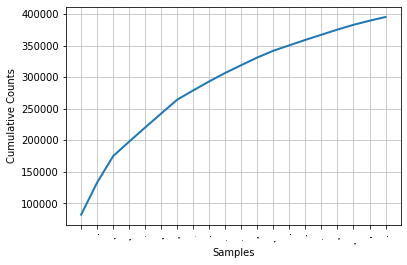

In [32]:
_ = analyze_corpus_charset(doc_data_df.text_content_clean1)

**Step2: Tokenization**

The goal is to convert documents from a character stream into sequence of words, while at the same removing non-word characters (punctuation, whitespace, etc).

In [33]:
# hide

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, regexp_tokenize

In [34]:
doc_data_df['text_content_clean2'] = doc_data_df.text_content_clean1.map(lambda doc: regexp_tokenize(doc,"\w+"))

In [40]:
print(doc_data_df.text_content_clean1[0][0:100])

[بالاعتماد على تحقيق يوسف شوقي.]
[الرسالة منقوصة في بدايتها.]
و « ك » إلى « ا »
وقد بينا أن فضل
فإذا


In [41]:
print(doc_data_df.text_content_clean2[0][0:10])

['بالاعتماد', 'على', 'تحقيق', 'يوسف', 'شوقي', 'الرسالة', 'منقوصة', 'في', 'بدايتها', 'و']


**Step3: remove stop words and short words**

In [43]:
stop_words_ar_raw = stopwords.words('arabic')
stop_words_ar = [normalize_arabic_letters(word,norm_alif=False) for word in stop_words_ar_raw]

In [44]:
# did any stop words change after orthographic normalization?

[(x,y) for x,y in zip(stop_words_ar_raw,stop_words_ar) if x!=y]

[]

In [48]:
doc_data_df['text_content_clean3'] = doc_data_df.text_content_clean2.map(lambda doc_tokens: [tok for tok in doc_tokens if (tok not in stop_words_ar and len(tok)>=3)])

In [49]:
print(doc_data_df.text_content_clean2[0][0:10])

['بالاعتماد', 'على', 'تحقيق', 'يوسف', 'شوقي', 'الرسالة', 'منقوصة', 'في', 'بدايتها', 'و']


In [50]:
print(doc_data_df.text_content_clean3[0][0:10])

['بالاعتماد', 'تحقيق', 'يوسف', 'شوقي', 'الرسالة', 'منقوصة', 'بدايتها', 'وقد', 'بينا', 'فضل']


**Step4: Normalization of special domain-specific terminology**

The goal of this preprocessing step is to normalize orthographic variations of special domain-specific terminology based on a small dictionary of terms provided by the domain expert.

Generic word normalization heuristics (such as light stemming) are based on morphology rules of the language and hence do not work on borrowed (non-Arabic) words and proper nouns. For this reason, we requested that the domain expert provide a small set of domain-specific keywords that fall under this category and that should not undergo stemming. Furthermore, these words are often spelled/written in different ways. Such variations are called orthographic variations, and they can be due to natural orthographic evolution of the word over time, or lack of a standard for the transliteration of non-Arabic words into Arabic.

We achieve this via a semi-automatic heuristic method. First we find all words in the corpus that are orthographically similar[^1] to the word of interest. Next we visually inspect them and remove incorrect matches. Finally, we replace all occurrences of the remaining matching words in the corpus with the word of interest. 

This method is just a simple heuristic and is not expected to be fool proof. Example false negative: 'رست' and 'راست'

[^1] We use edit distance as a measure of orthographic similarity.</span>

In [84]:
from nltk import edit_distance

In [72]:
# hide

from collections import defaultdict

In [76]:
MAX_WORD_LEN_DIFF = 2
MAX_WORD1_LEN = 6
MAX_WORD2_LEN = 6

def find_orth_word_variants(corpus_tokens,norm_words):
    '''function that implements our heuristic method for finding 
    all orthographic variants of a given set of important words.
    The orthographic variants of a word are different ways of writing it.
    We simply use edit distance to find orthographically similar words.
    Input: list of tokenized documents; list of important words.
    Output: dictionary containing a map of each important word and its corresponding list of orthographic variants in the corpus.
    '''
    corpus_tokens_list = [tok for doc in corpus_tokens for tok in doc]
    corpus_tokens_dict = Counter(corpus_tokens_list)
    corpus_distinct_words_list = sorted(list(corpus_tokens_dict.keys()))
    assert len(corpus_distinct_words_list)==len(corpus_tokens_dict)

    word_variants_dict = defaultdict(list)
    word_variants_reverse_dict = dict()

    # just in case some special words don't have any matches
    for word in norm_words:
        word_variants_dict[word] = []

    for word in corpus_distinct_words_list:
        word_ = word
        #custom light stemming ...
        if len(word)>=5 and word.startswith('ال'):
            word = word[2:]
        n1 = len(word)
        for special_word in norm_words:
            n2 = len(special_word)
            u1= (word==special_word or word.startswith(special_word) or word.endswith(special_word))
            u2= (n1>=MAX_WORD1_LEN and n2>=MAX_WORD2_LEN and abs(n2-n1)<=MAX_WORD_LEN_DIFF and edit_distance(special_word,word)<=2)
            #u3 = (abs(n2-n1)<=MAX_WORD_LEN_DIFF and edit_distance(special_word,word)==1)
            if u1 or u2:
                assert word_ not in word_variants_reverse_dict
                word_variants_dict[special_word].append(word_)
                word_variants_reverse_dict[word_] = special_word

    assert len(word_variants_dict)==len(norm_words)

    return word_variants_dict,word_variants_reverse_dict

Get the list of special important words from a file.

In [67]:
special_words_raw =[]
with open('../resources/special_vocabulary.txt', 'r', encoding='utf8') as f:
    for line in f:
        special_words_raw.append(line.strip())
len(special_words_raw)

18

In [68]:
special_words_raw

['اصفهان',
 'حجاز',
 'راست',
 'زركشي',
 'زروكند',
 'زنكلاه',
 'شهناز',
 'عراق',
 'نيروز',
 'بزرك',
 'سلمك',
 'كوشت',
 'ماياه',
 'نوى',
 'أبوسليك',
 'عشاق',
 'حسيني',
 'رهاوي']

In [69]:
# perform orthographic normalization on these words

special_words = [normalize_arabic_letters(word,norm_alif=False) for word in special_words_raw]

In [70]:
# check if any of these words changed after orthographic normalization

[(x,y) for x,y in zip(special_words_raw,special_words) if x!=y]

[]

In [80]:
word_variants_dict,word_variants_reverse_dict = find_orth_word_variants(doc_data_df.text_content_clean3.tolist(),special_words)

In [85]:
len(word_variants_dict),len(word_variants_reverse_dict)

(18, 154)

In [78]:
word_variants_df = pd.DataFrame(word_variants_dict.items(), columns=['special_word','word_variants'])
word_variants_df.set_index('special_word',inplace=True)

In [92]:
u = word_variants_df.word_variants.map(len)
assert u.sum() == len(word_variants_reverse_dict)

print("Number of variants for each special word:\n")
df = pd.DataFrame(u).reset_index()
df.columns = ['special word','number of variants in corpus']
df

Number of variants for each special word:



,special word,number of variants in corpus
0,اصفهان,19
1,حجاز,13
2,راست,4
3,زركشي,6
4,زروكند,16
5,زنكلاه,3
6,شهناز,7
7,عراق,10
8,نيروز,9
9,بزرك,11


In [86]:
print("The variants of each special word:\n")

for special_word,variants in word_variants_df.iterrows():
    print(special_word)
    print(variants[0])
    print()

The variants of each special word:

اصفهان
['إصبهان', 'إصفهان', 'اصبهان', 'اصبهانه', 'اصفهان', 'اصفهاناسمه', 'اصفهاني', 'الأصفهان', 'الإصبهان', 'الإصفهان', 'الاصبهان', 'الاصفهان', 'باصفهان', 'بالاصفهان', 'للاصفهان', 'واصبهان', 'واصفهان', 'والاصفهان', 'وللاصفهان']

حجاز
['الحجاز', 'الحجازى', 'الحجازي', 'الحجازيون', 'بالحجاز', 'حجاز', 'حجازا', 'حجازنا', 'حجازي', 'حجازية', 'للحجاز', 'والحجاز', 'وبالحجاز']

راست
['الراست', 'راست', 'فالراست', 'للراست']

زركشي
['الزركشي', 'بالزركشي', 'زركشي', 'للزركشي', 'والزركشي', 'وزركشي']

زروكند
['الزروكند', 'الزوركند', 'الزيرفكند', 'الزيلكند', 'بالزروكند', 'زرفكند', 'زروكند', 'زروكندا', 'زروكندي', 'زوركند', 'زيرفكند', 'زيلكند', 'لزرفكند', 'للزروكند', 'والزروكند', 'وزروكند']

زنكلاه
['زنكولا', 'والزنكلاه', 'وزنكلا']

شهناز
['الشهناز', 'شهناز', 'شهنازا', 'شهنازنا', 'شهنازها', 'شهنازي', 'والشهناز']

عراق
['العراق', 'العراقي', 'بالعراق', 'عراق', 'عراقي', 'فالعراق', 'للعراق', 'والعراق', 'وعراق', 'وللعراق']

نيروز
['النيروز', 'النيروزي', 'بالنيروز', 'للنيروز'

**Step5: Light stemming**

Currently we use the [Tashaphyne](https://pypi.org/project/Tashaphyne/) Arabic light stemmer.

In [ ]:
from tashaphyne.stemming import ArabicLightStemmer

# Vector Representation of Text

# Document Clustering

****

SCRATCH PAD

In [ ]:
# hide

u = doc_data_df.text_content.str.findall(DIACRITIC_MARKS_REGEX)
u.map(len).describe()

u.head()

sorted(list({hex(ord(y)) for x in u for y in x}))

Counter([(y,hex(ord(y))) for x in u for y in x])

In [ ]:
# hide

s = u"\u063a\u064a\u0646\u064a\u0627"
s = 'ه'
s = "ة"
hex(ord(s))

print('\u0632')

c1 = u'\u0632'
c2 = r'\u0632'
c = '\u0632'
x = ord(c)
y = hex(x)
z = chr(x)
list(map(type,[c1,c2,c,x,y,z])),list(map(len,[c1,c2,c,y,z])),c1==c,z==c